In [219]:
#Note: we denote L2 for euclidian norm and l2 for function norm (we switched the standard nomenclature)
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Extracting the results

In [220]:
from os import listdir
from os.path import isfile, join
import pickle
import pandas as pd
simu_folder = "2017-06-12_18.06.44"
folder = "/Users/mehdi/Downloads/"+simu_folder+"/"
onlyfiles = [f for f in listdir(folder) if (isfile(join(folder, f)) and f.startswith("res_K"))]

def data_extract_from_files(onlyfiles):
    for f in onlyfiles:
        yield pickle.load(open(folder+f)), f

In [221]:
data_tree = {}
for k in [0, 10,50,100]:
    data_tree[k]={}
    for n in [100 , 500, 1000]:
        data_tree[k][n]=[]
        
for f in onlyfiles:
    split = f.split('K')[1].split("N")
    for K in [0, 10,50,100]:
        if split[0]==str(K):
            K_ = K
    if split[1].startswith("500"):
        N_ = 500
    else :
        if pickle.load(open(folder+f))["rect_data"].shape[0] == 100:
            N_ = 100
        else:
            N_ = 1000
    data_tree[K_][N_].append(f)

In [222]:
import numpy as np
import uuid


In [223]:
from scipy.stats import multivariate_normal

def construct_pdf_gmm(model, n_pdf):
    """
    Construct the pdf of the estimated Gaussian mixture
    """
    components = []
    for m, var in zip(model.means_, model.covariances_):
        components.append(multivariate_normal(m, var)) 
    return np.apply_along_axis(lambda x: model.weights_.dot(np.array([d.pdf(x) for d in components])), 0, np.linspace(0,1,n_pdf))   

In [224]:
from pythonABC.hselect import hsj
from scipy.stats import gaussian_kde
from scipy.stats import entropy

def get_non_zero_weights(v):
    return np.array(zip(*[(idx, val) for (idx, val) in  enumerate(v) if val !=0]))

def results_extract(r):
    #return dict
    #
    densities = r["densities"]
    res = {}
    for type_dens in ["lapl_gauss", "uniform", "rect", "lapl_gauss_not_dict", "gauss"]:
        f_star = r[type_dens+"_f_star"]
        n_pdf = f_star.shape[0]
        x = np.linspace(0,1,n_pdf)
        #extract weight_estim
        res_weights_estim = r[type_dens+"_weight_vector_estim_lambda"]
        selected_densities_estim, weights_estim = get_non_zero_weights(res_weights_estim)
        f_weight_estim = np.apply_along_axis(lambda x: weights_estim.dot(np.array([densities[i].pdf(x) for i in selected_densities_estim.astype(int)])), 0, np.linspace(0,1,n_pdf))
        #removing non positive values:
        f_weight_estim[f_weight_estim <= 0] == 1e-20
        #extract adapative_dantzig
        lambda_adapative_dantzig = r[type_dens+"_adapative_dantzig"]
        f_adapative_dantzig = np.apply_along_axis(lambda x: lambda_adapative_dantzig.dot(np.array([d.pdf(x) for d in densities])), 0, np.linspace(0,1,n_pdf))        
        #removing non positive values:
        f_adapative_dantzig[f_adapative_dantzig <= 0] == 1e-20
        #Extract KDE
        f_kde= r[type_dens+"_kde"]
        #Extract KDE-hsj
        f_kde_hsj= r[type_dens+"_kde_hsj"]        
        #Perform kernel density estim
        res[type_dens+"_L2_norm_weight_estim"] = 1./n_pdf*np.linalg.norm(f_star-f_weight_estim,axis=0)**2
        res[type_dens+"_KL_div_weight_estim"] = entropy(f_star, f_weight_estim)
        res[type_dens+"_L2_norm_adapative_dantzig"] = 1./n_pdf*np.linalg.norm(f_star-f_adapative_dantzig,axis=0)**2
        res[type_dens+"_KL_div_adapative_dantzig"] = entropy(f_star, f_adapative_dantzig)
        res[type_dens+"_L2_norm_kde"] = 1./n_pdf*np.linalg.norm(f_star-f_kde,axis=0)**2
        res[type_dens+"_KL_div_kde"] = entropy(f_star, f_kde)
        res[type_dens+"_L2_norm_kde_hsj"] = 1./n_pdf*np.linalg.norm(f_star-f_kde_hsj,axis=0)**2
        res[type_dens+"_KL_div_kde_hsj"] = entropy(f_star, f_kde_hsj)
        if type_dens == "cvx":
            cvx_lambda_fstar = cvx_lambda_f_star(len(densities), r["selected_densities"])
            res[type_dens+"_L2_lambda_adapative_dantzig"] = np.linalg.norm(cvx_lambda_fstar- r["cvx_adapative_dantzig"])
            res[type_dens+"_L2_lambda_weight_estim"] = np.linalg.norm(cvx_lambda_fstar- extract_lambda(r["cvx_weight_vector_estim_lambda"],len(densities)))
        #extract MLE GMM
        f_em_bic = construct_pdf_gmm(r[type_dens+"_mle_bic_model"], n_pdf=n_pdf)
        res[type_dens+"_KL_div_em_bic"] = entropy(f_star, f_em_bic)
        res[type_dens+"_L2_norm_em_bic"] = 1./n_pdf*np.linalg.norm(f_star-f_em_bic,axis=0)**2
        #temps
        res[type_dens+"_mle_time"] = r[type_dens+"_mle_time"]
        res[type_dens+"_kde_time"] = r[type_dens+"_kde_time"]
        res[type_dens+"_kde_sj_time"] = r[type_dens+"_kde_sj_time"]
        res[type_dens+"_ad_time"] = r[type_dens+"_ad_time"]
        res[type_dens+"_em_bic_time"] = r[type_dens+"_mle_bic_time"]
    return res

In [225]:
#cvx case:
def dataframe_gen(temp_res, type_f_star):
    data = {type_f_star+"_KL_div_weight_estim":[],
            type_f_star+"_KL_div_adapative_dantzig":[],
            type_f_star+"_KL_div_kde":[],
            type_f_star+"_KL_div_kde_hsj":[],
            type_f_star+"_L2_norm_weight_estim":[],
            type_f_star+"_L2_norm_adapative_dantzig":[],
            type_f_star+"_L2_norm_kde":[],
            type_f_star+"_L2_norm_kde_hsj":[],
            type_f_star+"_KL_div_em_bic":[],
            type_f_star+"_L2_norm_em_bic":[],
            type_f_star+"_mle_time": [],
            type_f_star+"_kde_time": [],
            type_f_star+"_kde_sj_time": [],
            type_f_star+"_ad_time": [],
            type_f_star+"_em_bic_time": []
           }
    if type_f_star == "cvx":
        data["cvx_L2_lambda_weight_estim"] = [temp_res["cvx_L2_lambda_weight_estim"]]
        data["cvx_L2_lambda_adapative_dantzig"] = [temp_res["cvx_L2_lambda_adapative_dantzig"]]

    data[type_f_star+"_KL_div_weight_estim"].append(temp_res[type_f_star+"_KL_div_weight_estim"])
    data[type_f_star+"_KL_div_adapative_dantzig"].append(temp_res[type_f_star+"_KL_div_adapative_dantzig"])
    data[type_f_star+"_KL_div_kde"].append(temp_res[type_f_star+"_KL_div_kde"])
    data[type_f_star+"_KL_div_kde_hsj"].append(temp_res[type_f_star+"_KL_div_kde_hsj"])
    data[type_f_star+"_KL_div_em_bic"].append(temp_res[type_f_star+"_KL_div_em_bic"])
    data[type_f_star+"_L2_norm_weight_estim"].append(temp_res[type_f_star+"_L2_norm_weight_estim"])
    data[type_f_star+"_L2_norm_adapative_dantzig"].append(temp_res[type_f_star+"_L2_norm_adapative_dantzig"])
    data[type_f_star+"_L2_norm_kde"].append(temp_res[type_f_star+"_L2_norm_kde"])
    data[type_f_star+"_L2_norm_kde_hsj"].append(temp_res[type_f_star+"_L2_norm_kde_hsj"])
    data[type_f_star+"_L2_norm_em_bic"].append(temp_res[type_f_star+"_L2_norm_em_bic"])
    data[type_f_star+"_mle_time"].append(temp_res[type_f_star+"_mle_time"])
    data[type_f_star+"_kde_time"].append(temp_res[type_f_star+"_kde_time"])
    data[type_f_star+"_kde_sj_time"].append(temp_res[type_f_star+"_kde_sj_time"])
    data[type_f_star+"_ad_time"].append(temp_res[type_f_star+"_ad_time"])
    data[type_f_star+"_em_bic_time"].append(temp_res[type_f_star+"_em_bic_time"])
    
    return pd.DataFrame(data)

In [226]:
df_results = None
for K in [0]:
    for N in [100, 500, 1000]:
        object_list = data_extract_from_files(data_tree[K][N])
        for r, f in object_list:
            res_extract = results_extract(r)
            res = None
            for type_f_star in ["lapl_gauss", "uniform", "rect", "lapl_gauss_not_dict", "gauss"]:
                df_extract_temp = dataframe_gen(res_extract, type_f_star)
                if type(res) == pd.core.frame.DataFrame:
                    res = res.join(df_extract_temp)
                else:
                    res = df_extract_temp
            res = res.join(pd.DataFrame({"K":[K],"N":[N], "file":f}))
            if type(df_results) == pd.core.frame.DataFrame:
                    df_results = df_results.append(res)
            else:
                    df_results = res
                    

In [227]:
def retrieve_type(row):
    type_row=row["Type"]
    type_dens = "None"
    if "KL" in type_row:
        metric = "KL"
    else:
        metric = "L2"
    for t in ["lapl_gauss_not_dict", "lapl_gauss", "uniform", "rect", "gauss"]:
        if t == type_row.split("_"+metric)[0]:
            type_dens = t
    if "weight_estim" in type_row:
            method = "MLE"
    if "adapative_dantzig" in type_row:
            method = "A.D"
    if "kde" in type_row:
            if "hsj" in type_row:
                method = "KDE SJ"
            else:
                method = "KDE"
    if "bic" in type_row:
            method = "EM-BIC"    
    return pd.Series({"metric":metric, "type_dens":type_dens, "method": method})
df_results.to_csv("./full_results_N_100_500_1000_"+simu_folder+".csv")
df_without_times = df_results[[c for c in df_results.columns if "time" not in c]]
df3 = pd.melt(df_without_times.drop(["K","file"], axis=1), id_vars=["N"], var_name="Type", value_name="Loss")
df5 = pd.concat([df3,df3.apply(retrieve_type, axis=1)], axis=1)
df5.to_csv("./cleaned_results_N_100_500_1000_"+simu_folder+".csv")

In [228]:
df3

,N,Type,Loss
0,100,lapl_gauss_KL_div_adapative_dantzig,inf
1,100,lapl_gauss_KL_div_adapative_dantzig,inf
2,100,lapl_gauss_KL_div_adapative_dantzig,inf
3,100,lapl_gauss_KL_div_adapative_dantzig,inf
4,100,lapl_gauss_KL_div_adapative_dantzig,inf
5,100,lapl_gauss_KL_div_adapative_dantzig,inf
6,100,lapl_gauss_KL_div_adapative_dantzig,inf
7,100,lapl_gauss_KL_div_adapative_dantzig,inf
8,100,lapl_gauss_KL_div_adapative_dantzig,inf
9,100,lapl_gauss_KL_div_adapative_dantzig,inf


# Generation plots of Thesis Document

In [2]:
import pandas as pd
df5 = pd.read_csv("./cleaned_results_N_100_500_1000_"+simu_folder+".csv")
set(df5["method"])

{'A.D', 'EM-BIC', 'KDE', 'KDE SJ', 'MLE'}

In [24]:
%matplotlib inline

In [215]:
import seaborn as sns
def generate_boxplots(df, type_dens, metric):
    plt.figure(figsize=(5,5))
    sns.set_style("whitegrid")
    sns.despine()
    sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1})
    boxplot = sns.boxplot(x="method", y="Loss", hue="N", data=df[(df.metric==metric) & (df.type_dens==type_dens)],
                         palette=["#ff6666", "#ffd966", "#b3ff66"])
    for patch in boxplot.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 1))    
    sns_plot = boxplot.get_figure()
    #sns_plot.savefig("../../phd-thesis/TeX_files/output_"+type_dens+"_"+metric+".png")


/usr/local/lib/python2.7/site-packages/matplotlib/cbook.py:2073: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/usr/local/lib/python2.7/site-packages/matplotlib/cbook.py:2074: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


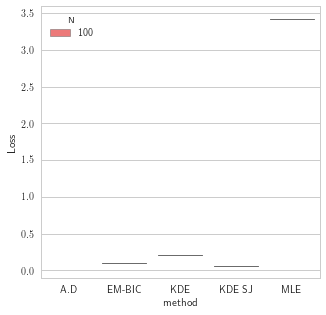

In [218]:
generate_boxplots(df5, "rect", "KL")

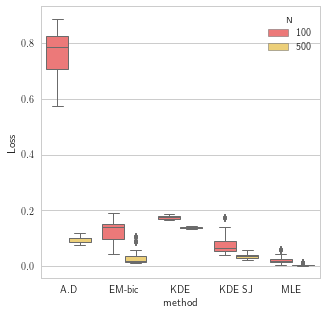

In [ ]:
for type_dens in df5.type_dens.unique():
    for metric in ["KL", "L2"]:
        generate_boxplots(df5, type_dens, metric)

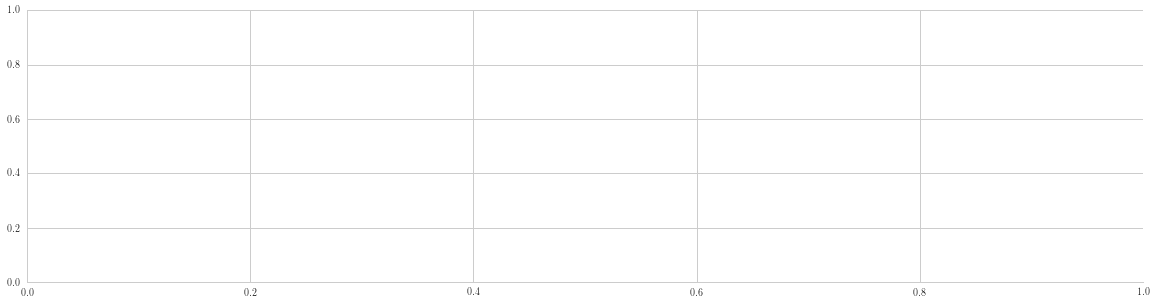

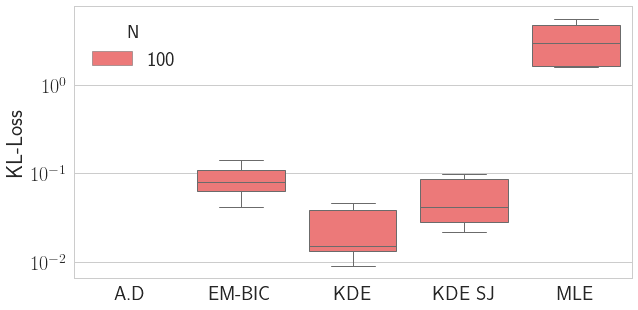

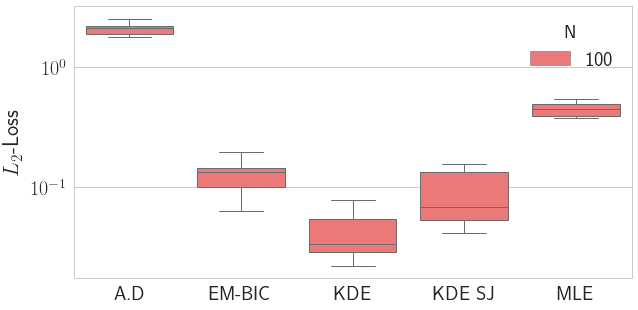

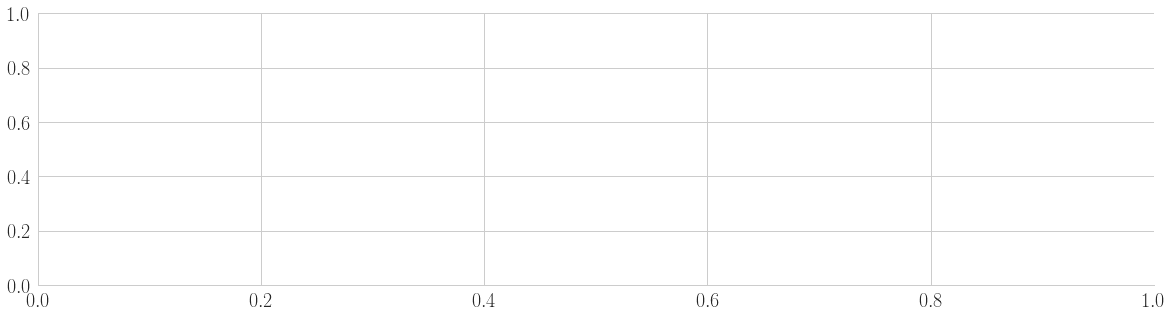

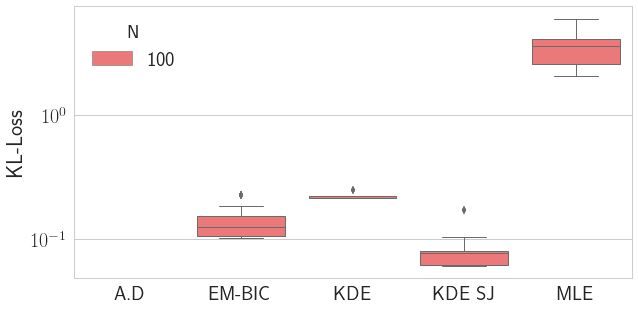

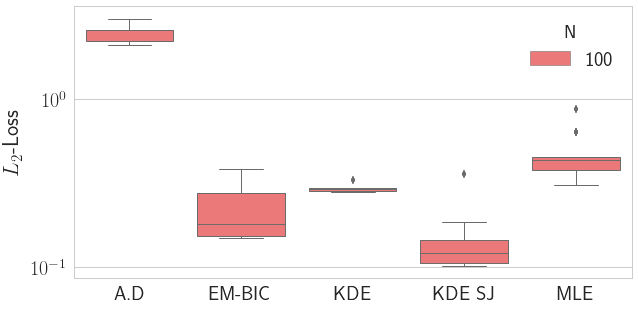

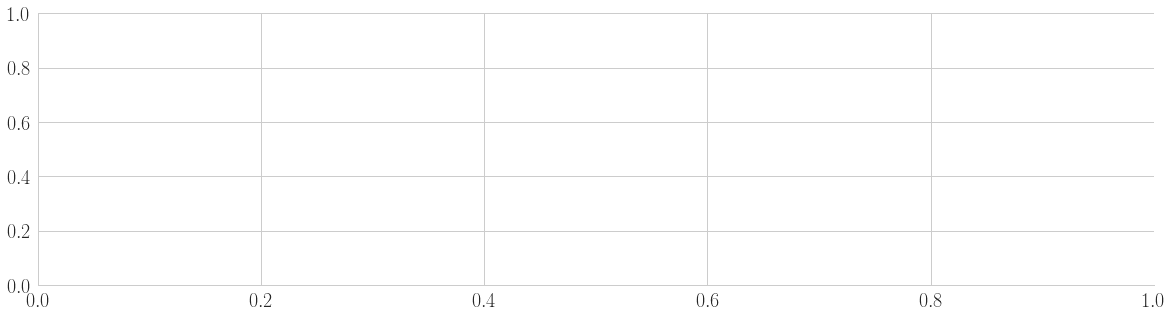

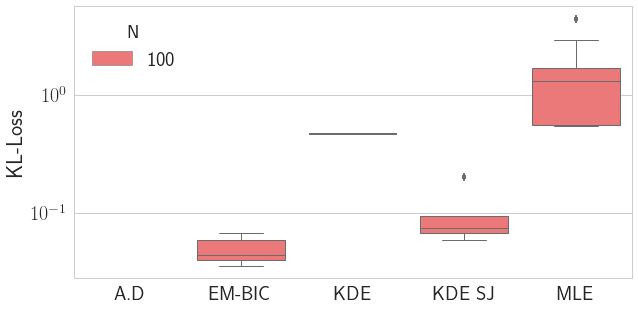

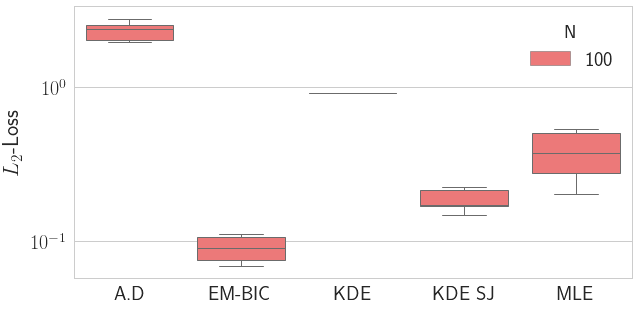

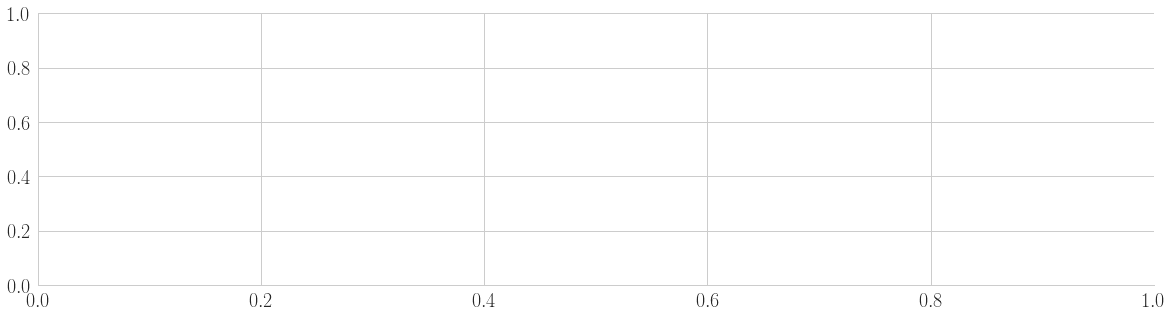

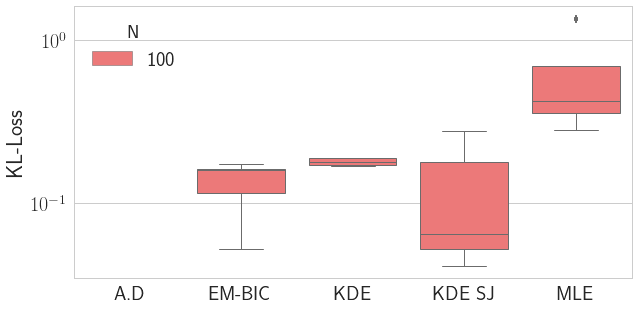

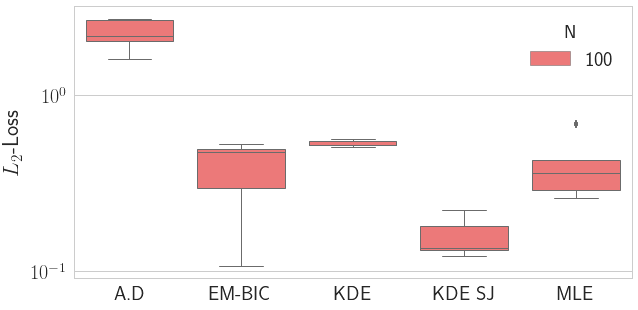

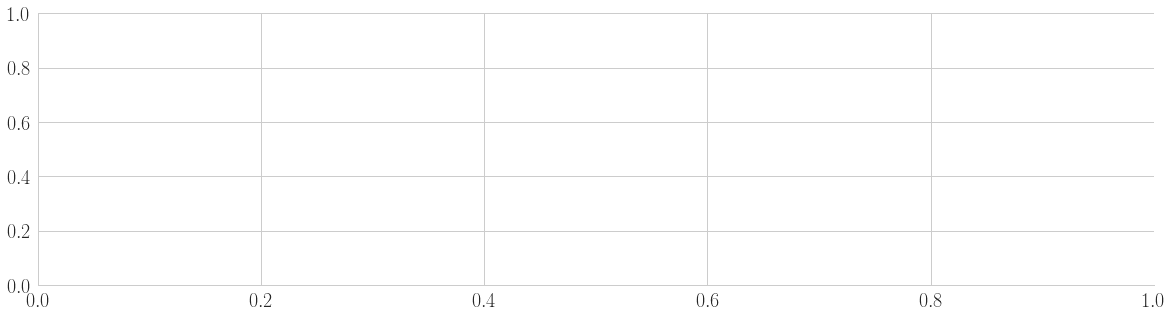

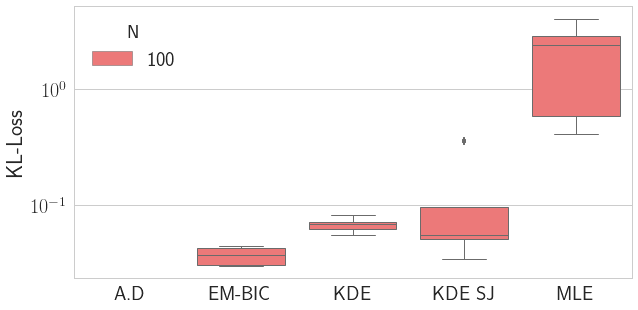

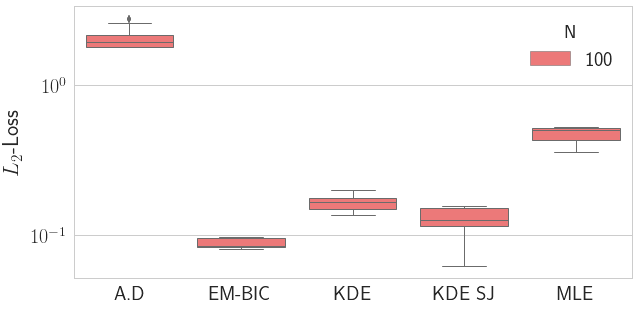

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns
def test(df, type_dens, metric):
    plt.figure(figsize=(10,5))
    boxplot = sns.boxplot(x="method", y="Loss", hue="N", data=df[(df.metric==metric) & (df.type_dens==type_dens)],
                         palette=["#ff6666", "#ffd966", "#b3ff66"])
    for patch in boxplot.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 1))
    boxplot.set_xlabel('')
    if metric == 'L2':
        boxplot.set_ylabel(r'$L_2$-Loss')
    else:
        boxplot.set_ylabel(metric+'-Loss')
    sns_plot = boxplot.get_figure()
    for ax in sns_plot.get_axes():
        ax.set_yscale('log')
    sns_plot = boxplot.get_figure()
    sns_plot.savefig("../../phd-thesis/TeX_files/res_temp_"+type_dens+"_"+metric, dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)



for type_dens_list in ['uniform', 'rect', 'gauss', 'lapl_gauss','lapl_gauss_not_dict']:
    plt.subplots(figsize=(20,5))
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    sns.set_style("whitegrid")
    sns.despine()
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})
    for type_dens in [type_dens_list]:
        for metric in ["KL", "L2"]:
            test(df5, type_dens, metric)
            

# Time graphs

In [132]:
def retrieve_type2(row, metric=True):
    type_row=row["Type"]
    type_dens = "None"
    for t in ["uniform", "rect", "gauss", "lapl_gauss", "lapl_gauss_not_dict"]:
        if t in type_row:
            type_dens = t
    if "mle" in type_row:
            method = "MLE"
    if "ad" in type_row:
            method = "A.D"
    if "kde" in type_row:
            if "sj" in type_row:
                method = "KDE SJ"
            else:
                method = "KDE"
    if "bic" in type_row:
            method = "EM-BIC"
    return pd.Series({"type_dens":type_dens, "method":method})

In [133]:
selected_time_col = ["N"]+[c for c in df_results.columns if "time" in c]
df6 = df_results[selected_time_col]
df7 = pd.melt(df6, id_vars=["N"], var_name="Type", value_name="Time")
df_times = pd.concat([df7, df7.apply(retrieve_type2, axis=1)], axis=1)
df_times.to_csv("./times_N_100_500_1000_09-06-2017.csv")

In [162]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

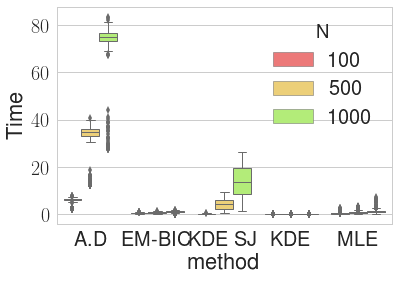

In [163]:
boxplot = sns.boxplot(x="method", y="Time", hue="N", data=df_times,
                         palette=["#ff6666", "#ffd966", "#b3ff66"])

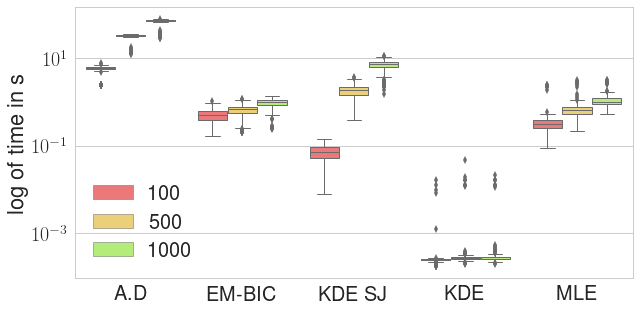

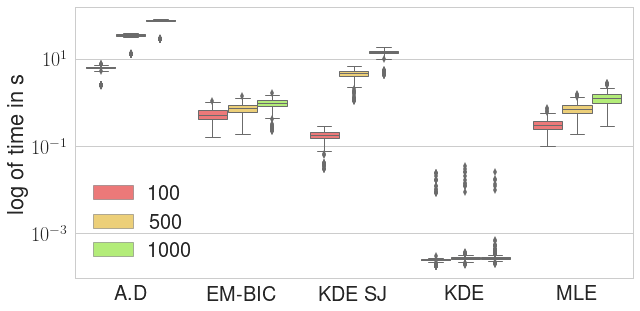

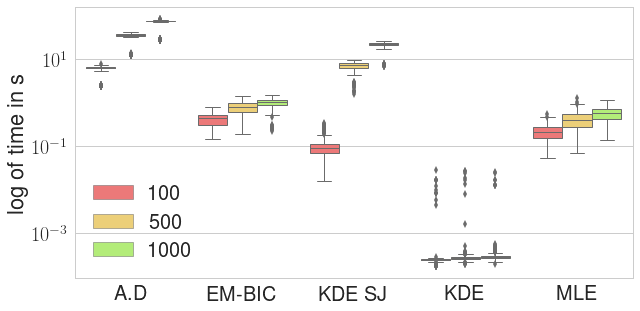

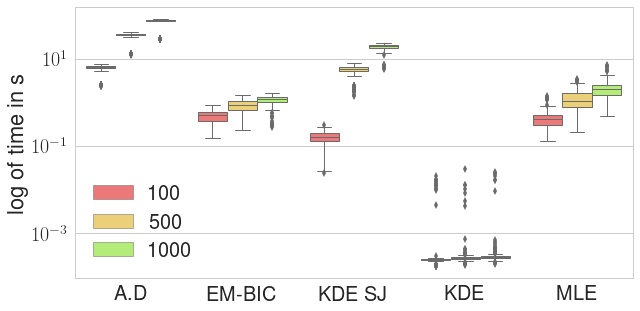

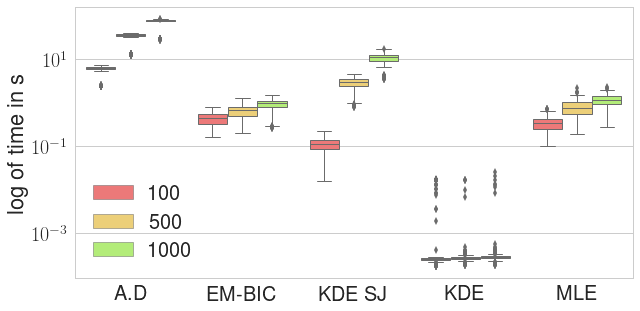

In [169]:
for type_dens in ["uniform", "rect", "gauss", "lapl_gauss", "lapl_gauss_not_dict"]:
    plt.figure(figsize=(10,5))
    df_temp = df_times[df_times["type_dens"]==type_dens]
    boxplot = sns.boxplot(x="method", y="Time", hue="N", data=df_temp,
                         palette=["#ff6666", "#ffd966", "#b3ff66"])
    for patch in boxplot.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 1))
    boxplot.set_xlabel('')
    boxplot.set_ylabel("log of time in s")
    sns_plot = boxplot.get_figure()
    for ax in sns_plot.get_axes():
        ax.set_yscale('log')
        ax.legend(bbox_to_anchor=(0, 0))
    plt.legend()
    sns_plot = boxplot.get_figure()
    sns_plot.savefig("../../phd-thesis/TeX_files/res_"+type_dens+"_times", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)
    


In [129]:
set(df_times["method"])

{'A.D', 'EM-BIC', 'KDE', 'MLE'}

In [152]:
for method in set(df_times["method"]):
    for type_dens in set(df_times["type_dens"]):
        print method+" "+type_dens+" "+ str(df_times[(df_times["method"]==method) & (df_times["type_dens"]==type_dens)]["Time"].mean())

A.D lapl_gauss_not_dict 36.7971072826
A.D gauss 36.7338945569
A.D lapl_gauss 36.9801004966
A.D rect 36.4985946966
A.D uniform 35.960048531
KDE lapl_gauss_not_dict 0.000968456990791
KDE gauss 0.000881979682229
KDE lapl_gauss 0.000943643035311
KDE rect 0.00107781634186
KDE uniform 0.000753101435575
MLE lapl_gauss_not_dict 0.742347902601
MLE gauss 0.402376371803
MLE lapl_gauss 1.26917068778
MLE rect 0.757463545872
MLE uniform 0.749637297789
EM-BIC lapl_gauss_not_dict 0.648249967893
EM-BIC gauss 0.716014663378
EM-BIC lapl_gauss 0.798619221196
EM-BIC rect 0.726409083424
EM-BIC uniform 0.70628320051
KDE SJ lapl_gauss_not_dict 4.36580923904
KDE SJ gauss 9.23305264459
KDE SJ lapl_gauss 7.85552396919
KDE SJ rect 6.0317786401
KDE SJ uniform 3.01914943168


In [160]:
df8 = df_times.groupby(["N","method","type_dens"])['Time'].median()

In [161]:
df8

N     method  type_dens          
100   A.D     gauss                   6.349774
              lapl_gauss              6.362319
              lapl_gauss_not_dict     6.267431
              rect                    6.257073
              uniform                 6.119935
      EM-BIC  gauss                   0.433444
              lapl_gauss              0.496767
              lapl_gauss_not_dict     0.433443
              rect                    0.516396
              uniform                 0.513456
      KDE     gauss                   0.000241
              lapl_gauss              0.000241
              lapl_gauss_not_dict     0.000249
              rect                    0.000243
              uniform                 0.000241
      KDE SJ  gauss                   0.087767
              lapl_gauss              0.160714
              lapl_gauss_not_dict     0.109815
              rect                    0.180218
              uniform                 0.072813
      MLE     gauss       

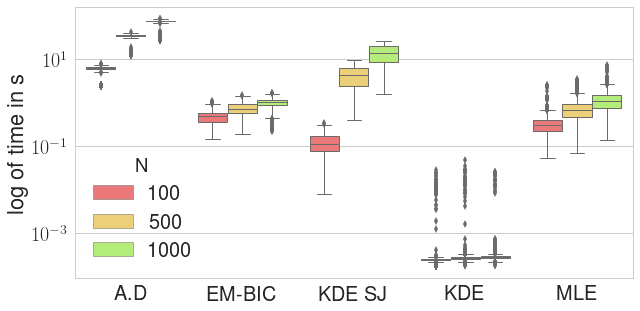

In [168]:
#merge all types of densities
plt.figure(figsize=(10,5))
boxplot = sns.boxplot(x="method", y="Time", hue="N", data=df_times,
                     palette=["#ff6666", "#ffd966", "#b3ff66"])
for patch in boxplot.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))
boxplot.set_xlabel('')
boxplot.set_ylabel("log of time in s")
sns_plot = boxplot.get_figure()
for ax in sns_plot.get_axes():
    ax.set_yscale('log')
sns_plot = boxplot.get_figure()
sns_plot.savefig("../../phd-thesis/TeX_files/res_times", dpi=100, transparent=True, bbox_inches='tight', pad_inches=0)



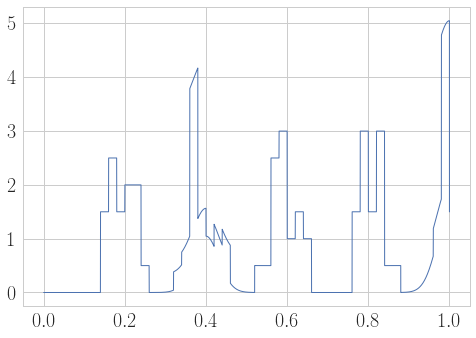

In [246]:
a = pickle.load(open(folder+"/res_K0N100_18230237-76ca-4f01-b3b9-b03676e4514d"))
f_w = a["gauss_weight_vector_estim_lambda"]
fstar_ = a["gauss_f_star"]
n_pdf = fstar_.shape[0]
def get_non_zero_weights(v):
    return np.array(zip(*[(idx, val) for (idx, val) in  enumerate(v) if val !=0]))
x = np.linspace(0,1,n_pdf)
#extract weight_estim
selected_densi, weights_esti = get_non_zero_weights(f_w)
f_weight_ = np.apply_along_axis(lambda x: weights_esti.dot(np.array([a["densities"][i].pdf(x) for i in selected_densi.astype(int)])), 0, np.linspace(0,1,n_pdf))

plt.plot(x, f_weight_)

In [233]:
folder+"/res_K0N100_18230237-76ca-4f01-b3b9-b03676e4514d"

'/Users/mehdi/Downloads/2017-06-12_18.06.44//res_K0N100_18230237-76ca-4f01-b3b9-b03676e4514d'

In [240]:
a["densities"]